# Angular power spectra
Now that we have taken a look at the theoretical matter power spectrum, we turn to the angular power spectra which we can relate to the actual observations of the CMB. For the matter power spectrum we look at the anisotropies due to primordial fluctuations in the matter fields of the primordial plasma. For the angular power spectra however, we turn to *the* cosmological probe, the cosmic microwave background (CMB).

The cosmic microwave background owes its name due to the fact that this is, to us, the first ever cosmic radiation we can observe. In some way this is the furthest we can look back into the universe. The cosmic microwave background refers to all photons emittes at last scattering/recombination. These photons have been redshifted into the microwace regime, throughout the evolution of the universe.
The CMB looks to be homogeneous and isotropic in 'larger' scales but contains anisotiropies in both photon temperature and polarzations. It is our job and goal to relate these anisotropies to the matter fluctuations in the primordial plasma.

To talk about:
- connection $C_{l} \propto P(k)$, through temperature fluctuations, conservation of superhorizon modes.
- All possible probes of angular power spectra and the ones we are interested in.
- Auto-correlations and cross-correlations:
    - 3x2pt
    - 6x2pt
    - 10x2pt
- Quantification: $\Delta \chi^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1} \left(C_{l}^{1} - C_{l}^{2}\right)$ of the correlations and the possible improvements on constraints

Literature to look at:
- **[6x2pt](https://arxiv.org/abs/2409.17377)**
- **[Neutrinos in $C_{l}$ and $P(k)$](https://arxiv.org/abs/1712.07109)**
- **[CCLX: generalized tracers](https://github.com/LSSTDESC/CCLX/blob/master/GeneralizedTracers.ipynb)**
- **[CCLX: angular power spectra](https://github.com/LSSTDESC/CCLX/blob/master/Angular%20cross-correlations.ipynb)**
- **[Weinberg; chapters 2.6, 7 & 8]()**

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import math
%matplotlib inline

In [2]:
# We define the cosmology from which we obtain the angular power spectra:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Compare this to the cosmology we get using the 'boltzmann_class' transfer function:
cosmo_class = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                            transfer_function='boltzmann_class')
# print(cosmo, "\n", cosmo_class)

In [ ]:
"""
For the matter power spectrum we looked at one specific redshift. For the (cross-correlations of the) angular power spectra, we include all the redshift in shich we can observe the Universe,
thus we are possibly interested in all redshifts for which: 0 < z < 1100  
"""

# For redshift dependent functions: we define the redshifts we look at, and define the redishift distributions:
z = np.linspace(0,1.2,1000)

# Set up the ranges of k, a, the redshift distributions:
ks = np.logspace(-5, 2, 1000)
scale_factor = (1./(1+z))[::-1]

# The redshift distributions accompanying the galaxy clustering tracer and weak lensing tracer:
nz1 = np.exp(-((z-0.5)/0.05)**2/2)
# nz2 = np.exp(-((z-0.65)/0.05)**2/2)
nz2 = (46. * 100.31 * (26. - 25.)) * 1./(2.*(0.0417*26. - 0.744)) * (z / (0.0417*26. - 0.744))**2. * np.exp(-z/(0.0417*26. - 0.744))

# We must also define the bias functions:
bz = 0.95/ccl.growth_factor(cosmo,1./(1+z)) # bias
sz = np.ones_like(z) # Magnification bias
az = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

## Tracers
We look at:
- Galaxy clustering: the NumberCountsTracer within CCL; which will include the matter overdensity contribution, multiplied by a linear, scale invariant bias redshift-space distortions and magnification.
- Cosmic shear: the WeakLensingTracer; which includes the cosmic shear term due to lensing and intrinsic alignment from the L-NLA model, with a scale invariant IA amplitude
- CMB lensing: the CMBLensingTracer; from a single source redshift (usually set to $z = 1100$, zorresponding to the CMB)

Next to these, we find other tracers that contribute to the observed CMB anisotropies but that we will probably not consider for this research:
- Integrated Saches Wolfe effect (ISW); the contribution of the gravitational field fluctuations along the line of sight.
- Thermal Sunyaev Zel'Dovich (tSZ) Compton-y fluctuations; (Compton) scattering of CMB radiation with intergalactic electrons along the line of sight
- Cosmic Infrared Background (CIB) intensity map; infrared radiation originating from stellar dust along the line of sight 

In [13]:
# Dictionary to group all tracers together:
tracers = {}

# We define the tracers we are interested in:
# Starting with galaxy clustering:
gc_d = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz1), bias=(z, bz), mag_bias=None)
gc_d_nz2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz2), bias=(z, bz), mag_bias=(z, sz))
# gc_r = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, nz1), bias=None, mag_bias=None)
# gc_m = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz1), bias=None, mag_bias=(z, sz))
gc_a = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, nz1), bias=(z, bz), mag_bias=(z, sz)) # We can choose to include multiple bias functions

# Cosmic shear:
wl_s = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=None)
# wl_i = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=False, ia_bias=(z,az))
wl_a = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=(z,az))

# CMB Lensing:
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100.)
 

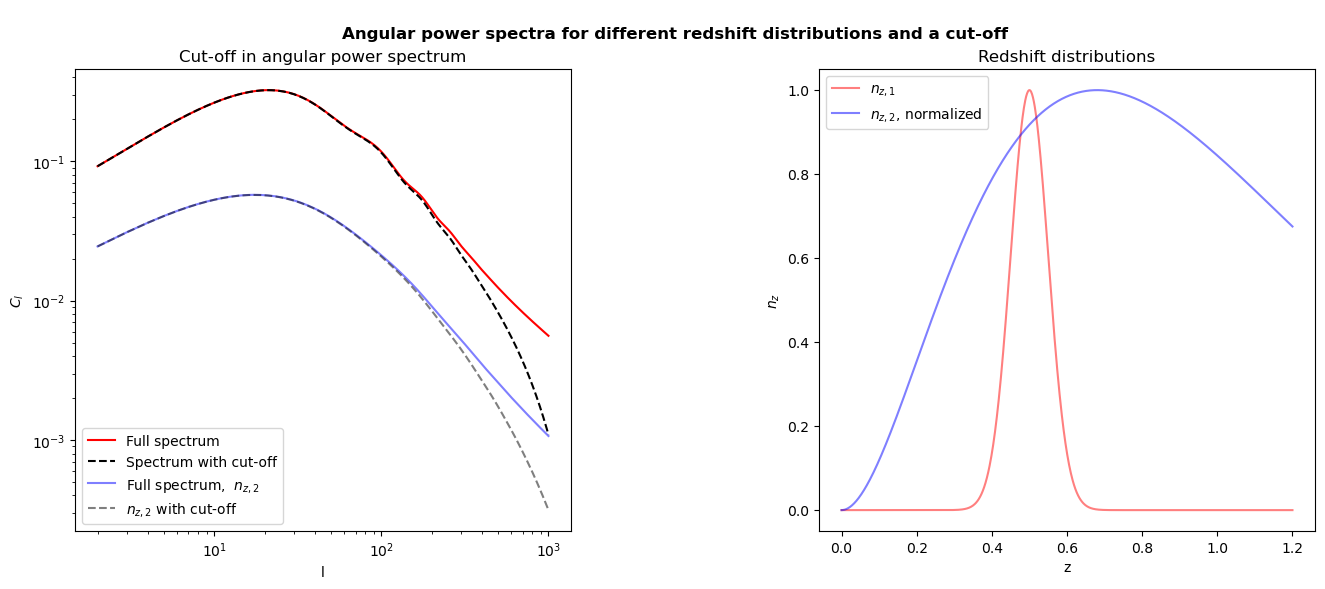

In [14]:
# Now we define a cut-off at small k and combine the angular power spectra for the situation with and without cut: 
lpk_array = np.log(np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in scale_factor]))

# Let us define a cut-off scale and implement the cut-off in the matter power spectrum:
k_cut = 0.4 # This corresponds to a scale of ~10 Mpc
lpk_array -= (ks/k_cut)**2

# All multipole moments for which we plot the angular power spectrum:
ells = np.linspace(2, 1000, 1000)

# By default, in ccl uses the non-linear matter power spectrum in the calculation for the angular power spectra; however, 
# a more general approach is to use the object Pk2D, which incirporates both the k and a dependence of the matter power spectrum.
pk_cut = ccl.Pk2D(a_arr=scale_factor, lk_arr=np.log(ks), pk_arr=lpk_array, is_logp=True)

# Now we define the angular power spectra for both the full matter power spectrum and the angular power spectra with cut-off:
# We do this for galaxy clustering, excluding rsd & magnification bias,
cl_gc_no_cut = ccl.angular_cl(cosmo, gc_d, gc_d, ells)
cl_gc_with_cut = ccl.angular_cl(cosmo, gc_d, gc_d, ells, p_of_k_a=pk_cut)

# Compare with the other redshift distribution:
cl_gc_no_cut_nz2 = ccl.angular_cl(cosmo, gc_d_nz2, gc_d_nz2, ells)
cl_gc_with_cut_nz2 = ccl.angular_cl(cosmo, gc_d_nz2, gc_d_nz2, ells, p_of_k_a=pk_cut)

# Initiate the plot:
fig, axes = plt.subplots(figsize=[16, 6], nrows=1, ncols=2)
plt.suptitle("\nAngular power spectra for different redshift distributions and a cut-off\n", weight='bold')
# plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

# Plot the two angular poiwer spectra:
axes[0].loglog(ells, 1e4*cl_gc_no_cut, 'r-', label='Full spectrum')
axes[0].loglog(ells, 1e4*cl_gc_with_cut, 'k--', label='Spectrum with cut-off')
axes[0].loglog(ells, 1e4*cl_gc_no_cut_nz2, 'b-', label=r'Full spectrum,  $n_{z, 2}$', alpha=0.5)
axes[0].loglog(ells, 1e4*cl_gc_with_cut_nz2, 'k--', label=r'$n_{z, 2}$ with cut-off', alpha=0.5)

# Plot-readability:
axes[0].set_title("Cut-off in angular power spectrum")
axes[0].legend()
axes[0].set_xlabel('l')
axes[0].set_ylabel(r'$C_{l}$')

# Plot the redshift distributions:
axes[1].plot(z, nz1, 'r-', label=r'$n_{z, 1}$', alpha=0.5)
axes[1].plot(z, nz2/np.max(nz2), 'b-', label=r'$n_{z, 2}$, normalized', alpha=0.5)

# Plot-readability:
axes[1].set_title("Redshift distributions")
axes[1].legend()
axes[1].set_xlabel('z')
axes[1].set_ylabel(r'$n_{z}$')
plt.show()

## Correlation functions:
Now we take a closer look at the cross correlations between angular power spectra. Above we defined all the angular power spectra we are interested in, now we will continue on those definitions


### Auto correlations:
Look at the auto correlations of the above defined angular power spectra;

**NOTE: check the actual definitions in [CCLX; CellsCorrelations](https://github.com/LSSTDESC/CCLX/blob/master/CellsCorrelations.ipynb)**

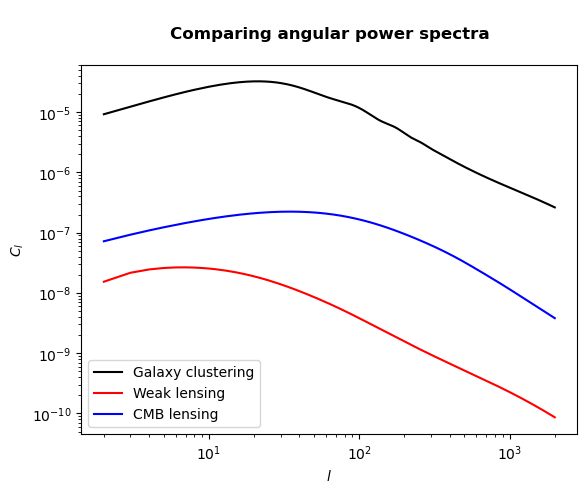

In [15]:
# Define angular power spectra, using the definitions of the tracers above:
ells = np.arange(2, 2000)

cls_wl = ccl.angular_cl(cosmo, wl_s, wl_s, ells)
cls_g_cl = ccl.angular_cl(cosmo, gc_d, gc_d, ells)
cls_cmb = ccl.angular_cl(cosmo, cmbl, cmbl, ells)

# Initiate the plot:
plt.figure()
plt.title("\nComparing angular power spectra\n", weight='bold')

# PLot angular power spectra:
plt.loglog(ells, cls_g_cl, 'k-', label='Galaxy clustering')
plt.loglog(ells, cls_wl, 'r-', label='Weak lensing')
plt.loglog(ells, cls_cmb, 'b-', label='CMB lensing')

# Readability of the plot:
plt.legend()
plt.xlabel('$l$')
plt.ylabel(r'$C_{l}$')
plt.show()

### Cross-correlations:
Look at the cross-correlations between different angular power spectra:


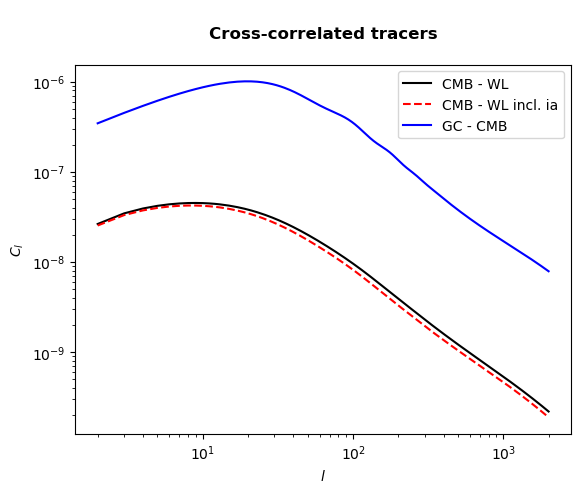

In [16]:
# Define the angular power spectra of cross correlated tracers:
cls_cmb_cross_lens1 = ccl.angular_cl(cosmo, wl_s, cmbl, ells)
cls_cmb_cross_lens1_a = ccl.angular_cl(cosmo, wl_a, cmbl, ells)
cls_cmb_cross_gc = ccl.angular_cl(cosmo, gc_a, cmbl, ells)

# Initiate the plot:
plt.figure()
plt.title("\nCross-correlated tracers\n", weight='bold')

# Plotting:
plt.loglog(ells, cls_cmb_cross_lens1, 'k-', label='CMB - WL')
plt.loglog(ells, cls_cmb_cross_lens1_a, 'r--', label='CMB - WL incl. ia')
plt.loglog(ells, cls_cmb_cross_gc, 'b-', label='GC - CMB')

# Uprgade the plot:
plt.legend()
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.show()

### Angular correlation function:
Compute the angular (cross-)correlations; 

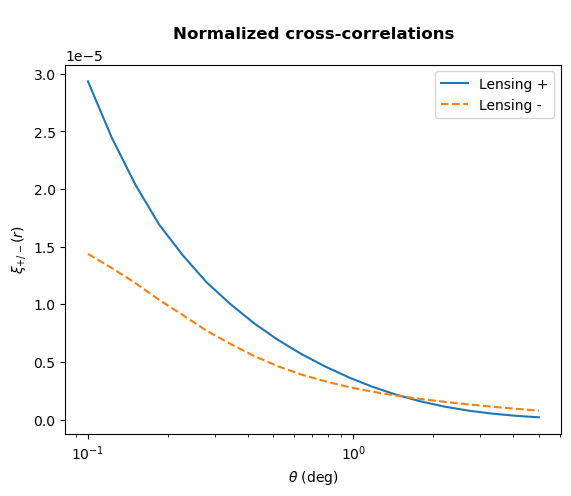

In [23]:
# Now we calculate the correlation functions:

# The angular scales on which we calculate the correlation functions:
theta = np.logspace(-1, np.log10(5.), 20) # in degrees

#Cosmic shear auto correlations:
xi_plus = ccl.correlation(cosmo, ell=ells, C_ell=cls_wl, theta=theta, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell=ells, C_ell=cls_wl, theta=theta, type='GG-', method='FFTLog')

#Clustering auto-correlation: 
xi_clu = ccl.correlation(cosmo, ell=ells, C_ell=cls_g_cl, theta=theta, type='NN', method='FFTLog')

# Plot:
plt.figure()
plt.title("\nNormalized cross-correlations\n", weight='bold')

# Plot the correlations:
# NOTE: the normalizations make absolutely no sense, but allow all cross-correlations to be visible in the same plot:
# plt.plot(theta, xi_plus/np.max(xi_plus), label='Normalized lensing +', alpha=0.5)
# plt.plot(theta, xi_minus/np.max(xi_minus), label='Normalized lensing -', alpha=0.5)
# plt.plot(theta, xi_clu/np.max(xi_clu), label='Normalized clustering', alpha=0.5)
plt.plot(theta, xi_plus, label='Lensing +')
plt.plot(theta, xi_minus, '--', label='Lensing -')
# plt.plot(theta, xi_clu, label='Clustering')

# Fancy it up:
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$\xi_{+/-} (r)$')
plt.show()